In [ ]:
## Import CNN implementation from cnn.py
from cnn import CNN

In [ ]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: cpu


In [ ]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size])

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


In [ ]:
# Initialize CNN model
cnn = load_model('cnn_model')
if cnn is None: 
    learning_rate = 0.001
    cnn = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn.train_cnn(10, optimizer, loss_fn, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)
    save_model(cnn, 'cnn_model')

No saved model found at saved_models\cnn_model.pkl
Epoch 1/10: Train loss=0.4230, Train acc=84.61%, Val loss=0.3059, Val acc=88.93%, Test acc=88.04%
Epoch 2/10: Train loss=0.2744, Train acc=89.98%, Val loss=0.2697, Val acc=90.25%, Test acc=89.82%
Epoch 3/10: Train loss=0.2269, Train acc=91.51%, Val loss=0.2360, Val acc=91.46%, Test acc=90.95%
Epoch 4/10: Train loss=0.1948, Train acc=92.68%, Val loss=0.2430, Val acc=91.33%, Test acc=90.95%
Epoch 5/10: Train loss=0.1642, Train acc=93.81%, Val loss=0.2448, Val acc=91.39%, Test acc=90.83%
Epoch 6/10: Train loss=0.1360, Train acc=94.83%, Val loss=0.2316, Val acc=92.23%, Test acc=91.84%
Epoch 7/10: Train loss=0.1145, Train acc=95.74%, Val loss=0.2651, Val acc=92.00%, Test acc=91.65%
Epoch 8/10: Train loss=0.0933, Train acc=96.50%, Val loss=0.2523, Val acc=92.27%, Test acc=91.96%
Epoch 9/10: Train loss=0.0738, Train acc=97.28%, Val loss=0.2792, Val acc=92.14%, Test acc=91.91%
Epoch 10/10: Train loss=0.0619, Train acc=97.70%, Val loss=0.2981, 

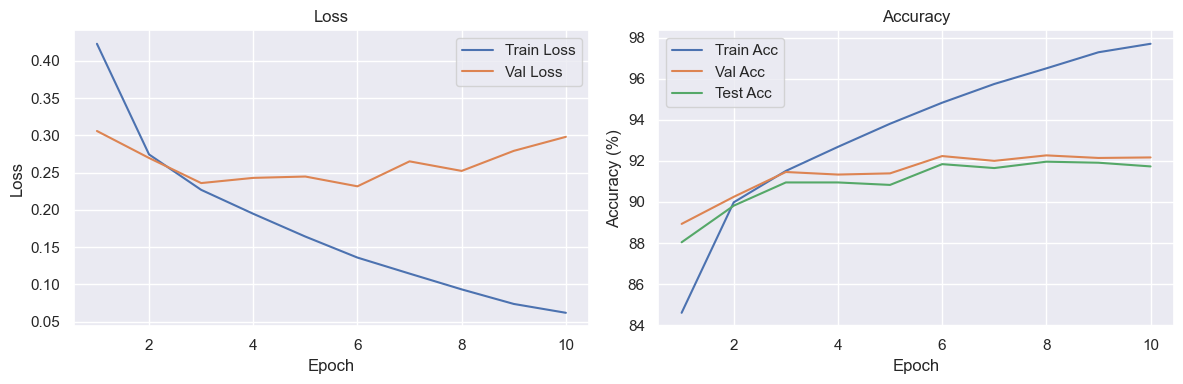

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, label='Train Loss')
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), [a*100 for a in cnn.train_accuracies_cnn], label='Train Acc')
plt.plot(range(1, cnn.num_epochs+1), [a*100 for a in cnn.val_accuracies_cnn], label='Val Acc')
plt.plot(range(1, cnn.num_epochs+1), [a*100 for a in cnn.test_accuracies_cnn], label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

(10, 10)


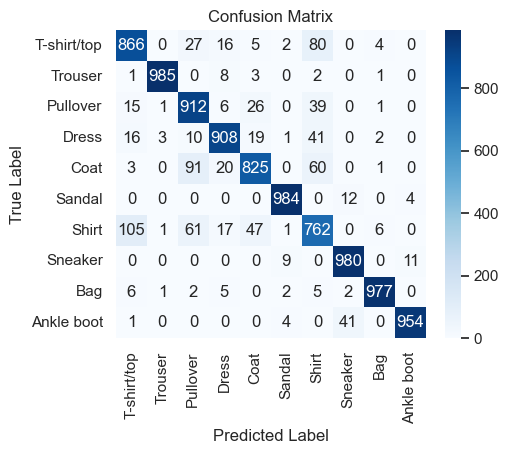

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = cnn(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
cnn_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

full_train_cnn_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn_data_augmentation))
val_size = len(full_train_cnn_data_augmentation) - train_size
# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn_data_augmentation, val_dataset_cnn_data_augmentation = random_split(full_train_cnn_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_cnn_data_augmentation = DataLoader(train_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=True)
val_loader_cnn_data_augmentation = DataLoader(val_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=False)
test_loader_cnn_data_augmentation = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

cnn_aug = load_model('cnn_model_augmented')
if cnn_aug is None:
    learning_rate = 0.001
    cnn_aug = CNN().to(device)
    optimizer = optim.Adam(cnn_aug.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    cnn_aug.train_cnn(10, optimizer, loss_fn, train_loader_cnn_data_augmentation, val_loader_cnn_data_augmentation, test_loader_cnn, device)
    save_model(cnn_aug, 'cnn_model_augmented')

No saved model found at saved_models\cnn_model_augmented.pkl
Epoch 1/10: Train loss=0.4618, Train acc=83.25%, Val loss=0.3462, Val acc=87.47%, Test acc=87.62%
Epoch 2/10: Train loss=0.3060, Train acc=88.75%, Val loss=0.2880, Val acc=89.31%, Test acc=89.68%
Epoch 3/10: Train loss=0.2598, Train acc=90.41%, Val loss=0.2755, Val acc=90.12%, Test acc=90.39%
Epoch 4/10: Train loss=0.2297, Train acc=91.49%, Val loss=0.2413, Val acc=91.33%, Test acc=91.22%
Epoch 5/10: Train loss=0.2090, Train acc=92.19%, Val loss=0.2371, Val acc=91.35%, Test acc=91.19%
Epoch 6/10: Train loss=0.1923, Train acc=92.83%, Val loss=0.2306, Val acc=91.62%, Test acc=91.42%
Epoch 7/10: Train loss=0.1778, Train acc=93.39%, Val loss=0.2343, Val acc=91.83%, Test acc=91.93%
Epoch 8/10: Train loss=0.1616, Train acc=93.95%, Val loss=0.2343, Val acc=91.93%, Test acc=91.89%
Epoch 9/10: Train loss=0.1516, Train acc=94.33%, Val loss=0.2280, Val acc=92.17%, Test acc=91.69%
Epoch 10/10: Train loss=0.1399, Train acc=94.79%, Val los

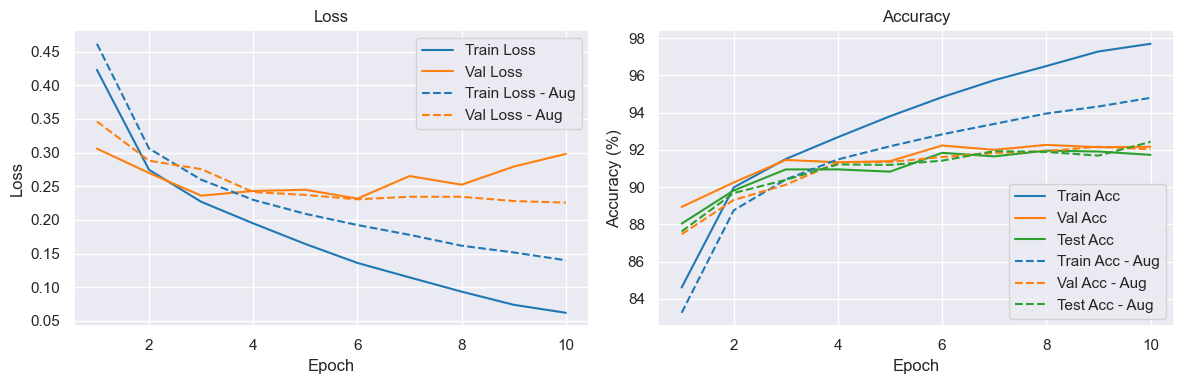

Training time without augmentation: 336.22 seconds
Training time with augmentation: 402.84 seconds


In [ ]:
# Plot training/validation history of augmented CNN on top of original CNN
plt.figure(figsize=(12,4))
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.subplot(1,2,1)
plt.plot(range(1, cnn.num_epochs+1), cnn.train_losses_cnn, label='Train Loss', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), cnn.val_losses_cnn, label='Val Loss', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.train_losses_cnn, label='Train Loss - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), cnn_aug.val_losses_cnn, label='Val Loss - Aug', linestyle='--', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, cnn.num_epochs+1), [a*100 for a in cnn.train_accuracies_cnn], label='Train Acc', color=colors[0])
plt.plot(range(1, cnn.num_epochs+1), [a*100 for a in cnn.val_accuracies_cnn], label='Val Acc', color=colors[1])
plt.plot(range(1, cnn.num_epochs+1), [a*100 for a in cnn.test_accuracies_cnn], label='Test Acc', color=colors[2])
plt.plot(range(1, cnn_aug.num_epochs+1), [a*100 for a in cnn_aug.train_accuracies_cnn], label='Train Acc - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, cnn_aug.num_epochs+1), [a*100 for a in cnn_aug.val_accuracies_cnn], label='Val Acc - Aug', linestyle='--', color=colors[1])
plt.plot(range(1, cnn_aug.num_epochs+1), [a*100 for a in cnn_aug.test_accuracies_cnn], label='Test Acc - Aug', linestyle ='--', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare training times
print(f"Training time without augmentation: {cnn.train_time:.2f} seconds")
print(f"Training time with augmentation: {cnn_aug.train_time:.2f} seconds")